## Kneser Ney Method for next word prediction

Kneser-Ney is a method primarily used to calculate the probability distribution of n-grams in a document based on their counts/histories in document.


#### Method


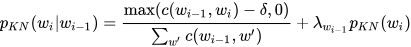




Where , `w` and `w'` are word followed by each other in corus.<br>
`delta` is a discounting factor.(Which can be tuned.)-1}}}`

In [209]:
from collections import OrderedDict,defaultdict
from nltk.util import ngrams
import string

In [210]:
class Conf:
    punctuations = '!"#$%&\()*+,-./:;=?@[\\]^_`{|}~'
    ngramLowerOrder = 2
    ngramHigherOrder = 6
    d = 0.75
    interpolation  = 0.4

In [211]:
def load_corpus(data,n,vocab_dict):
    ngram_dict = defaultdict(int)
    lines = data
    
    lines = ['<start> ' + x + ' <end>' for x in lines]
    for line in lines:
        temp_l = line.split()
        # print(temp_l)
        i = 0
        j = 0
        for word in temp_l :
            j = 0
            for l in word :
                if l in '!"#$%&\'()*+,-./:;=?@[\\]^_`{|}~':
                    if l == "'":
                        if j+1<len(word) and word[j+1] == 's':
                            j = j + 1
                            continue
                    word = word.replace(l," ")
                    #print(j,word[j])
                j += 1
            temp_l[i] = word.lower()
            i=i+1 
        content = " ".join(temp_l)
        token = content.split()
        if not token:
            continue
        ngrams_list = list(ngrams(token, n))
        # Building Vocabulary
        for word in token:
            if word not in vocab_dict.keys():
                vocab_dict[word] = 1
            else:
                vocab_dict[word] += 1
        # Building Ngram
        if ngrams_list == []:
            pass
        else:
            for t in ngrams_list:
                sen = ' '.join(t)
                ngram_dict[sen] += 1
    return ngram_dict

In [212]:
def create_kneser_ney_dict(ngram_dict, n):
    first_dict = {}
    sec_dict = {}
    for key in ngram_dict:
        ngram_token = key.split()
        n_1gram_sen = ' '.join(ngram_token[:n-1])
        if n_1gram_sen not in sec_dict:
            sec_dict[ n_1gram_sen ] = 1
        else:
            sec_dict[ n_1gram_sen ] += 1
            
        if ngram_token[-1] not in first_dict:
            first_dict[ ngram_token[-1] ] = 1
        else:
            first_dict[ ngram_token[-1] ] += 1
    
    return first_dict, sec_dict

In [264]:
def computeKnesserNeyProb2(ngram_dicts,vocab_dict,prob_dict):
    d = 0.75
    interpolation = 0.4
    for order in range(2, len(ngram_dicts) + 2):
        current_dict = ngram_dicts[order - 2]

        first_dict, sec_dict = create_kneser_ney_dict(current_dict, order)

        for ngram in current_dict:
            ngram_tokens = ngram.split()
            prefix = ' '.join(ngram_tokens[:-1])
            if prefix not in sec_dict:
                # Use lower-order n-gram probabilities as back-off
                prob_dict[prefix] = prob_dict.get(prefix, [])
                prob_dict[prefix].append([interpolation * vocab_dict[ngram_tokens[-1]] / sum(vocab_dict.values()), ngram_tokens[-1]])
                continue

            prob1 = max(current_dict[ngram] - d, 0) / sec_dict[prefix] if prefix in sec_dict else 0
            prob2 = d / sec_dict[prefix] * (first_dict[ngram_tokens[-1]] if ngram_tokens[-1] in first_dict else 0)

            for i in range(order - 2, 0, -1):
                ngram_prefix = ' '.join(ngram_tokens[i:-1])
                prob2 *= d / len(ngram_dicts[i - 1]) * (sec_dict[ngram_prefix] if ngram_prefix in sec_dict else 0)

            prob_dict[prefix] = prob_dict.get(prefix, [])
#             prob_dict[prefix].append([prob1 + prob2, ngram_tokens[-1]])
            prob_dict[prefix].append([(1 - interpolation) * (prob1 + prob2) + interpolation * vocab_dict[ngram_tokens[-1]] / sum(vocab_dict.values()), ngram_tokens[-1]])


In [265]:
def sort_prob_word_wict(prob_dict):
    for key in prob_dict.keys():
        if len(prob_dict[key])>0:
            prob_dict[key] = sorted(prob_dict[key],reverse = True)[:2]

In [266]:
def clean_input(sen):
    temp_l = sen.split()
    i = 0
    j = 0
    for word in temp_l:
        for l in word :
            if l in '!"#$%&\'()*+,-./:;=?@[\\]^_`{|}~':
                if l == "'":
                    if j+1<len(word) and word[j+1] == 's':
                        j = j + 1
                        continue
                word = word.replace(l," ")
            j += 1

        temp_l[i] = word.lower()
        i=i+1   
    content = " ".join(temp_l)
    return content


In [277]:
def predict_word(sen,prob_dict):
    n = len(sen.split(" "))
    sen = sen.split()
    
    for i in range(n-1):
        a =  " ".join(sen[i:])
        if a in prob_dict:
            return prob_dict[a]
        
    return ""

In [275]:
data = [x.strip() for x in open("../data/movie.txt").readlines()]
conf = Conf()
vocab_dict = defaultdict(int)
conf.ngramLowerOrder = 2
conf.ngramHigherOrder = 10
ngram_dicts = []
for i in range(conf.ngramLowerOrder,conf.ngramHigherOrder):
    ngram_dicts.append(load_corpus(data,i,vocab_dict))
print("-- Computing Ngrams --")
prob_dict = OrderedDict()
computeKnesserNeyProb2(ngram_dicts, vocab_dict,prob_dict)
print("-- Computing Kneser Ney Probablites --")
sort_prob_word_wict(prob_dict)
print("-- Sorting Proabblities --")

-- Computing Ngrams --
Completed
-- Computing Kneser Ney Probablites --
-- Sorting Proabblities --


In [286]:
while True:
    inp = input("Enter the sentence to predict : ")
    max_len= 5
    if inp.split() == [] and len(inp.split())>0:
        break
    if inp == "exit": 
        break
    inp = clean_input(inp)
    inp = f"<start> {inp}" 
    final_words = predict_word(inp,prob_dict)
    max = 0
    for words in final_words:
        if words[0]>0.1:
            print('Predicted :',inp.replace("<start>","").strip(),words[1])

Enter the sentence to predict :  can we


Predicted : can we go


Enter the sentence to predict :  are you


Predicted : are you sure


Enter the sentence to predict :  Hello
Enter the sentence to predict :  GOod


Predicted : good morning
Predicted : good luck


Enter the sentence to predict :  exit
